# Hanning window



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#libraries
import ipywidgets as widgets
from ipywidgets import interactive
import plotly.express as px
import plotly.graph_objects as go
import os
from scipy.stats import norm
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import norm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import linregress
import numpy as np
from scipy.signal import chirp, find_peaks, peak_widths
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks, peak_widths


## Read Data

In [ ]:
def read_d(path,end_fle):
  carpeta1=path
  archivos = os.listdir(carpeta1)
  archivos_csv2g = [archivo for archivo in archivos if archivo.endswith(f'{end_fle}')]
  rutas = [os.path.join(carpeta1, archivo) for archivo in archivos_csv2g]

  suma_total2 = pd.DataFrame()

  # Contador para llevar un registro de la cantidad de archivos
  num_archivos2 = 0

  # Iterar sobre los archivos CSV y sumar los DataFrames
  for archivo in rutas:
      df2 = pd.read_csv(archivo, skiprows=11)
      suma_total2 = suma_total2.add(df2, fill_value=0)
      num_archivos2 += 1

  # Calcular el promedio dividiendo la suma total por la cantidad de archivos
  signal2ms = suma_total2 / num_archivos2
  return signal2ms

In [ ]:
d20ms = read_d('/content/drive/MyDrive/LABO3','s_20ms')

## Clase analisis data Adquirida

In [ ]:

class signal_h_fft:
    def __init__(self, x, y, title, size):
        self.X = np.array(x)
        self.Y = np.array(y)
        self.title = title
        self.size = size
        self.Y_fft = None
        self.values_hanning = None
        self.Y_ffth= None
        self.frequencies=None

    def plots_s_h(self):
        # Applying the Hanning window
        hanning_window = np.hanning(len(self.Y))
        self.values_hanning = self.Y * hanning_window

        # Plotting the original signal and the signal with Hanning window
        plt.figure(figsize=self.size)
        plt.plot(self.X, self.Y, label=f'{self.title}', color='darkslateblue')
        plt.plot(self.X, self.values_hanning, label=f'{self.title} with Hanning Window', color='forestgreen')
        plt.title('Signal')
        plt.xlabel('Time')
        plt.ylabel('Amplitude')
        plt.legend()
        plt.grid(True)
        plt.show()

        return  {'time':self.X ,
                 'Values':self.Y,
                 'Values hanning':self.values_hanning}

    def fft_s_h(self, xlim=None, ylim=None):
        # Check if the Hanning windowed values are set
        if self.values_hanning is None:
            print("Hanning windowed values not set. Run plots_s_h first.")
            return

        N = len(self.X)
        T = self.X[1] - self.X[0]
        self.frequencies = np.fft.fftfreq(N, d=T)
        self.Y_ffth = np.fft.fft(self.values_hanning)
        amplitude_spectrum_h = np.abs(self.Y_ffth)
        self.Y_fft = np.fft.fft(self.Y)
        amplitude_spectrum = np.abs(self.Y_fft)

        plt.figure(figsize=self.size)# Crear una figura de tamaño 20x5

        # Primer subplot
        plt.subplot(1, 2, 1)
        plt.plot(np.abs(self.frequencies), amplitude_spectrum, label="Original Signal", color='darkslateblue')
        plt.plot(np.abs(self.frequencies), amplitude_spectrum_h, label="Signal with Hanning Window", color='forestgreen')
        plt.title("FFT")
        plt.xlabel('Frequency')
        plt.ylabel('Amplitude')
        if xlim is not None:
            plt.xlim(xlim)
        if ylim is not None:
            plt.ylim(ylim)
        plt.grid(True)
        plt.legend()

        # Segundo subplot
        plt.subplot(1, 2, 2)
        fft_db = 10*np.log10(amplitude_spectrum/amplitude_spectrum.max())
        ffth_db = 10*np.log10(amplitude_spectrum_h/amplitude_spectrum_h.max())
        plt.plot(np.abs(self.frequencies), fft_db, label="Original Signal", color='darkslateblue')
        plt.plot(np.abs(self.frequencies), ffth_db, label="Signal with Hanning Window", color='forestgreen')
        plt.title("FFT in dB")
        plt.xlabel('Frequency')
        plt.ylabel('Amplitude in dB')
        if xlim is not None:
            plt.xlim(xlim)

        plt.grid(True)
        plt.legend()

        plt.tight_layout()
        plt.show()

        return {'freq':self.frequencies,
                'fft':self.Y_fft,
                'ffth':self.Y_ffth,
                'fft_db': fft_db,
                'ffth_db': ffth_db}

    def cutpeak(self, tysignal, threshold, filter_mode, xlim=None, ylim=None):
        if tysignal == 'FFT' and self.Y_fft is not None:
            filtered_fft = self.Y_fft.copy()

            c='darkslateblue'
        elif tysignal == 'FFTh' and self.Y_ffth is not None:
            filtered_fft = self.Y_ffth.copy()
            c='forestgreen'
        else:
            print("FFT data not available or incorrect signal type.")
            return

        N = len(self.X)
        T = self.X[1] - self.X[0]
        frequencies = np.fft.fftfreq(N, d=T)
        filtered_amplitude = []

        for i, amplitude in enumerate(np.abs(filtered_fft)):
            if (filter_mode == 'low' and amplitude < threshold) or (filter_mode == 'high' and amplitude > threshold):
                filtered_fft[i] = 1e-10
            filtered_amplitude.append(1e-10 if filtered_fft[i] == 1e-10 else amplitude)

        # Plotting filtered FFT and its inverse
        plt.figure(figsize=self.size)

        plt.subplot(1, 3, 1)

        plt.plot(np.abs(frequencies), filtered_amplitude,color=c)
        #plt.title('FFT ')
        plt.xlabel('Frequency (Hz)', fontsize=16)
        plt.ylabel('Amplitude', fontsize=16)
        if xlim is not None:
            plt.xlim(xlim)
        if ylim is not None:
            plt.ylim(ylim)
        plt.title(f'{tysignal} (filter)', fontsize=20,)
        plt.grid(True)

        bd = 10*np.log(np.array(filtered_amplitude)/np.array(filtered_amplitude).max())
        plt.subplot(1, 3, 2)
        plt.plot(np.abs(frequencies), bd,color=c)

        plt.xlabel('Frequency (Hz)', fontsize=16)
        plt.ylabel('Amplitude in dB', fontsize=16)
        if xlim is not None:
            plt.xlim(xlim)

        plt.title(f'{tysignal} in dB (filter)', fontsize=20,)
        plt.grid(True)


        Y_filtered = np.fft.ifft(filtered_fft)
        plt.subplot(1, 3, 3)
        plt.plot(self.X, np.real(Y_filtered), '.',color=c)
        plt.xlabel('Time (s)', fontsize=16)
        plt.ylabel('Amplitude', fontsize=16)
        plt.title(f'{tysignal} inverse filter', fontsize=20)
        plt.grid(True)
        plt.tight_layout()
        plt.show()

        return {'freq':frequencies,
                'fft filtrada':filtered_fft}



## Funcion para determinar el ando de los picos

In [ ]:
def peak_width(x,y,xrang,yrang=None,title=None):
  # Encontrando los picos en la señal
  peaks, _ = find_peaks(y)
  # Filtro para encontrar picos dentro del rango de frecuencia deseado (800-2200 Hz)
  filtered_peaks = peaks[(x[peaks] >= xrang[0]) & (x[peaks] <= xrang[1])]
  # Cálculo de los anchos de los picos en su base
  results_full = peak_widths(y, filtered_peaks, rel_height=1)
  # Preparando el gráfico
  plt.figure(figsize=(14, 7))
  # Graficando la señal
  bandwidth_dict = {
      'n_pico': [],
      'ancho_de_banda_del_pico_rangos': [],
      'longitud_del_pico': [],
      'pico_con_mayor_amplitud': None,
      'Amplitud':None,
      'ancho_de_banda_pico_mayor_amplitud': None,
      'rango_de_banda_pico_mayor_amplitud':None
  }
  plt.plot(x, y, label='Signal')
  # Inicializando el diccionario para almacenar la información de los anchos de banda


  # Identificar el pico con la mayor amplitud
  peak_amplitudes = y[filtered_peaks]
  max_peak_amplitude = np.max(peak_amplitudes)
  max_peak_index = np.where(peak_amplitudes == max_peak_amplitude)[0][0]
  max_peak_freq = x[filtered_peaks][max_peak_index]

  # Dibujando líneas horizontales en la base de cada pico filtrado y anotando
  for i, (peak, width, left_ips, right_ips) in enumerate(zip(filtered_peaks, results_full[0], results_full[2], results_full[3])):
      # Convertir a int para usar como índices
      left_ip = int(left_ips)
      right_ip = int(right_ips)
      peak_ip = int(peak)

      # Asegúrate de que left_ip y right_ip son válidos y no causarán un error de índice
      if left_ip >= len(x) or right_ip >= len(x):
          continue

      # Calcula la altura de la base del pico
      height = results_full[1][i]
      left_x = x[left_ip]
      right_x = x[right_ip]
      pico_x = x[peak_ip]
      pico_y = y[peak_ip]
      distance = right_x - left_x

      # Añadiendo la información al diccionario
      bandwidth_dict['n_pico'].append(i+1)
      bandwidth_dict['ancho_de_banda_del_pico_rangos'].append((left_x, right_x))
      #bandwidth_dict['ancho_de_banda_del_pico_rangos']
      bandwidth_dict['longitud_del_pico'].append(abs(distance))

      if peak == filtered_peaks[max_peak_index]:
          # Dibujar la línea del ancho de banda para el pico con la mayor amplitud
          plt.hlines(height, left_x, right_x, color="C1", label='Width at base' if i == 1 else "")
          plt.text((left_x + right_x)/2, height, f'#{i+1}: {abs(distance):.2f} Hz', ha='center', va='bottom')
          # Actualizar el diccionario con el pico de mayor amplitud
          bandwidth_dict['rango_de_banda_pico_mayor_amplitud']=(left_x, right_x)
          bandwidth_dict['pico_con_mayor_amplitud'] = i+1
          bandwidth_dict['Amplitud']= max_peak_amplitude
          bandwidth_dict['ancho_de_banda_pico_mayor_amplitud'] = abs(distance)

  # Marcando los picos con una 'x'
  plt.plot(x[filtered_peaks], y[filtered_peaks], "x", label='Peaks')

  # Ajustando los límites de la gráfica al rango de frecuencia deseado y agregando leyendas y títulos
  plt.xlim(xrang[0], xrang[1])
  if yrang is not None:
    plt.ylim(yrang)
  #plt.ylim(0, 300)  # Un poco más arriba del máximo para visualizar mejor
  if title is not None:
    plt.title(title)
  else:
    plt.title('Peak Widths ')
  plt.xlabel('Frequency (Hz)')
  plt.ylabel('Magnitude (dB)')
  plt.legend()
  plt.grid(True)
  # Mostrando el gráfico
  plt.show()
  inf = {'Amplitude':bandwidth_dict['Amplitud'],
         'Widtth':bandwidth_dict['ancho_de_banda_pico_mayor_amplitud'],
         'Range width':sorted(bandwidth_dict['rango_de_banda_pico_mayor_amplitud'])}

  # Imprimiendo el diccionario de anchos de banda
  return [bandwidth_dict,inf]


#Tarea

##Data para las  2 ms

### Analisis de la data

In [ ]:
Signal_2ms = read_d('/content/drive/MyDrive/University/Data Aquisition/Lab 3/Data/Normal','signal_2ms.csv')
#datos de la fft y ffth para realizar la correspondiente comparativa
fft_2ms = read_d('/content/drive/MyDrive/University/Data Aquisition/Lab 3/Data/Normal','fft_2ms.csv')
ffth_2ms =read_d('/content/drive/MyDrive/University/Data Aquisition/Lab 3/Data/Normal','ffth_2ms.csv')

/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


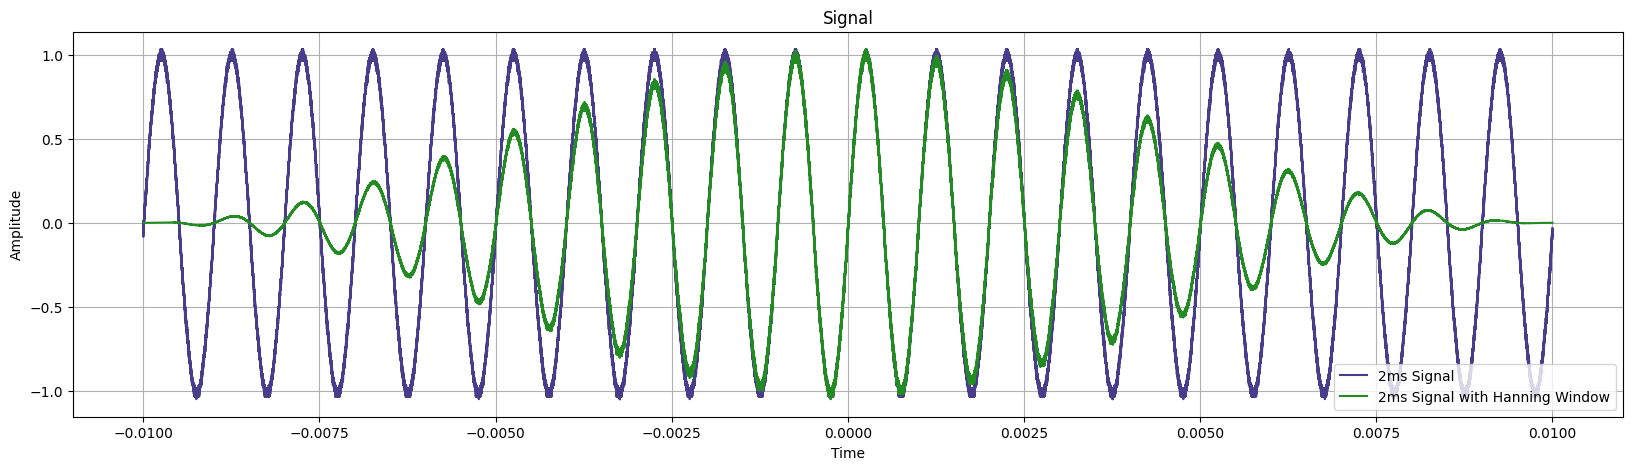

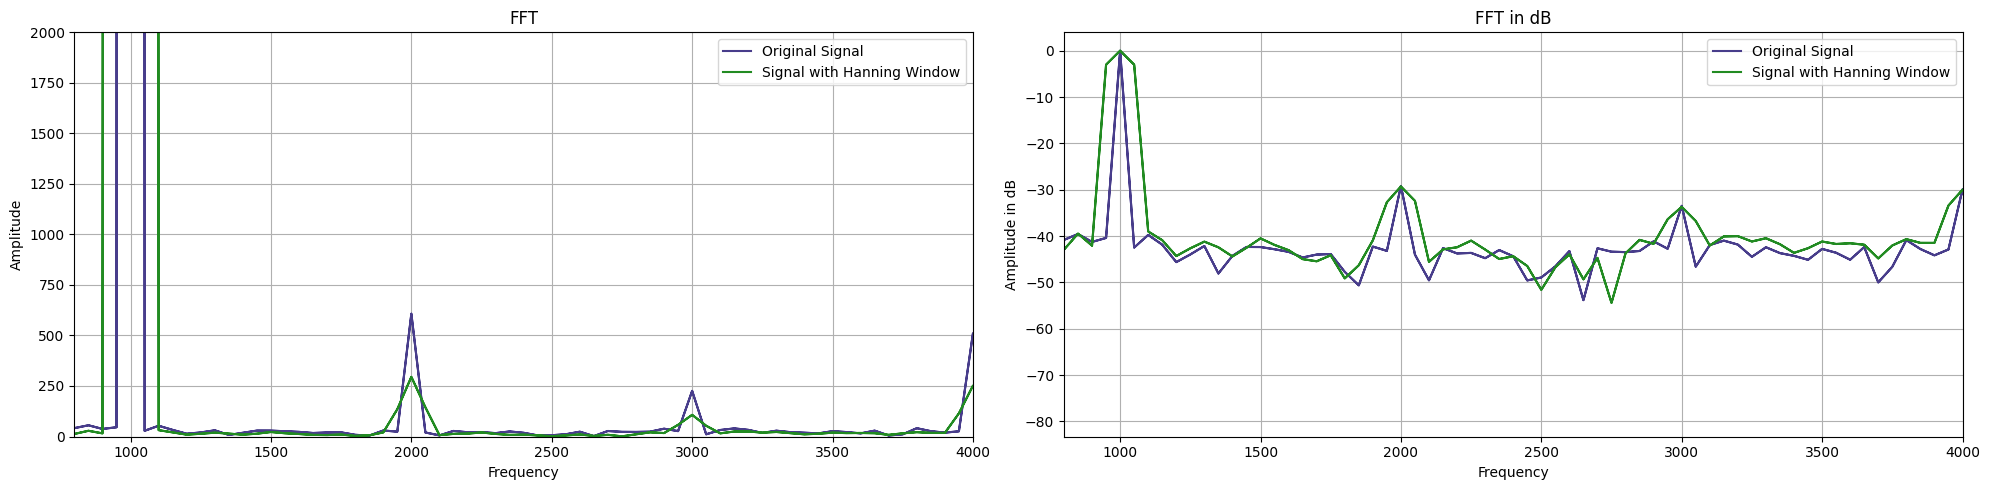

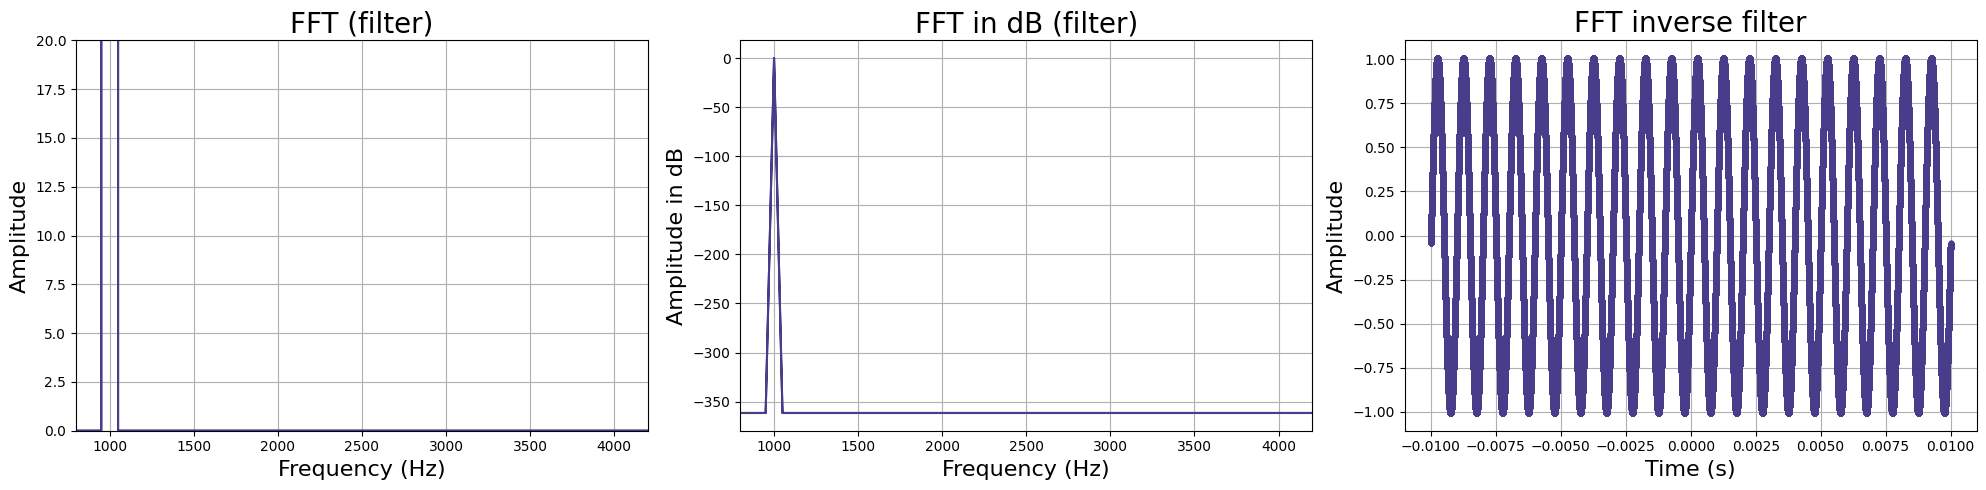

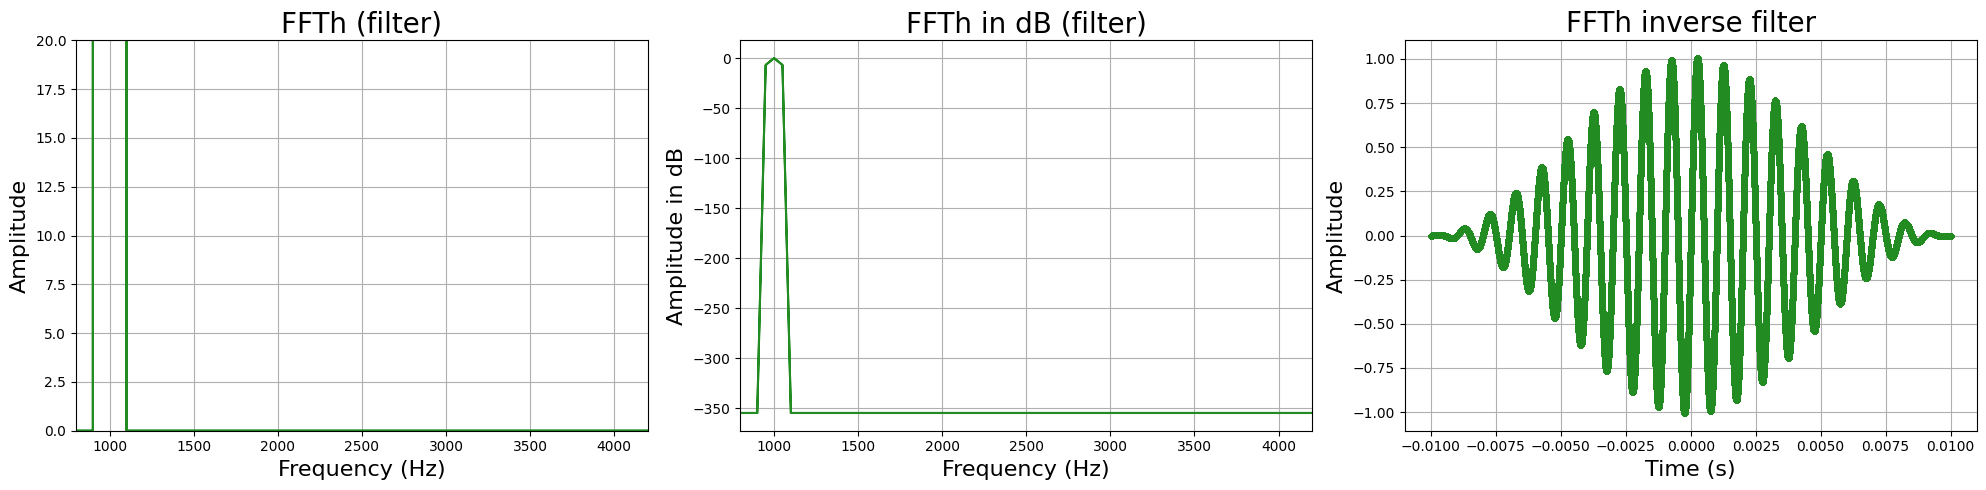

In [ ]:
FFT = signal_h_fft(Signal_2ms['Second'],Signal_2ms['Value'],'2ms Signal',(20,5))
haning = FFT.plots_s_h() # grafica y regesa los valores de la senal con el hannig
fft_s_h = FFT.fft_s_h(xlim=(800,4000),ylim=(-1,2000)) # regresa los. valores de las. frecuencias y de la fft y el fft del hanning asi como los valores en dB
Cut_fft= FFT.cutpeak(tysignal='FFT',threshold=4000,filter_mode='low',ylim=(0,20),xlim=(800,4200)) # experimental aplica un pic cutting para senal de la fft o de ffth
Cut_ffth= FFT.cutpeak(tysignal='FFTh',threshold=4000,filter_mode='low',ylim=(0,20),xlim=(800,4200))



### Determinacion del ancho de la Data

haciendo uso de la variable fft_s_h que retorna. los. valores de la fft y el hanning de la fft calcularemos el pico

In [ ]:
fft_s_h

{'freq': array([   0.,   50.,  100., ..., -150., -100.,  -50.]),
 'fft': array([-3853.27837158  +0.j        ,    98.11560221 +45.92249086j,
           23.22909805+132.35618551j, ...,   -29.59312053 +24.33168116j,
           23.22909805-132.35618551j,    98.11560221 -45.92249086j]),
 'ffth': array([-1975.69520857 +0.j        ,  1006.57040108-10.12494397j,
           -5.51672925+60.77994938j, ...,   -21.09103138+34.95919737j,
           -5.51672925-60.77994938j,  1006.57040108+10.12494397j]),
 'fft_db': array([-21.16079066, -36.67157791, -35.73577623, ..., -41.18578452,
        -35.73577623, -36.67157791]),
 'ffth_db': array([-21.05170027, -23.98023848, -36.15348023, ..., -37.89925159,
        -36.15348023, -23.98023848])}

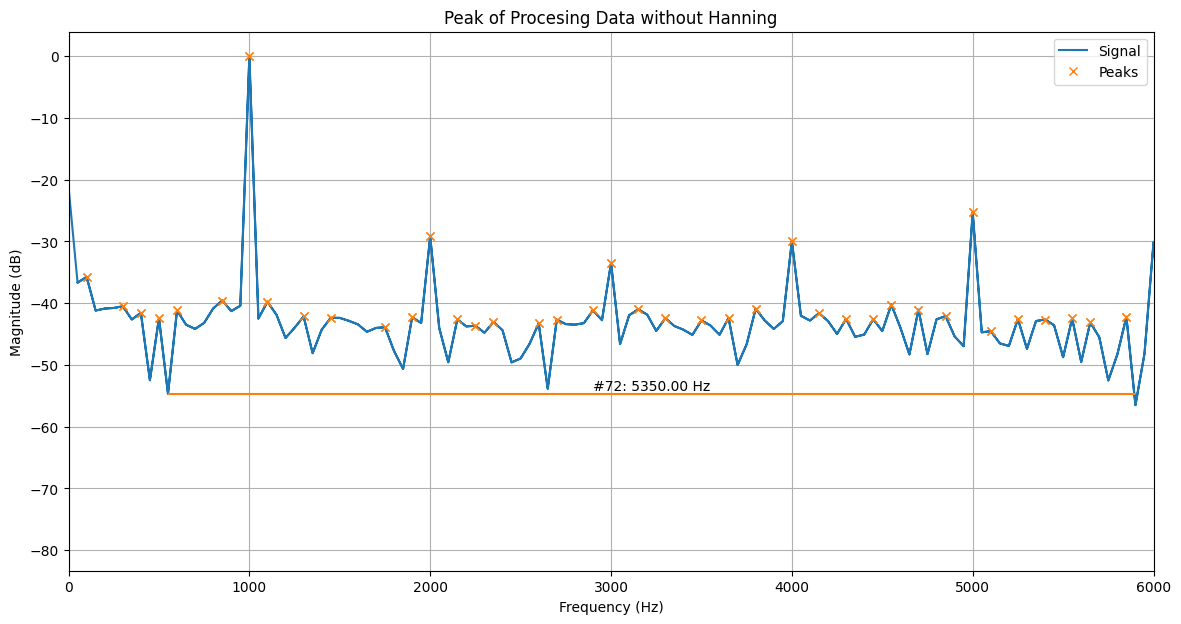

In [ ]:
Pw_fft_db=peak_width(abs(fft_s_h['freq']),(fft_s_h['fft_db']),xrang=(0,6000),yrang=None,title='Peak of Procesing Data without Hanning')


In [ ]:
Pw_fft_db[1]

{'Amplitude': 0.0,
 'Widtth': 5350.000000031773,
 'Range width': [550.0000000032663, 5900.000000035039]}

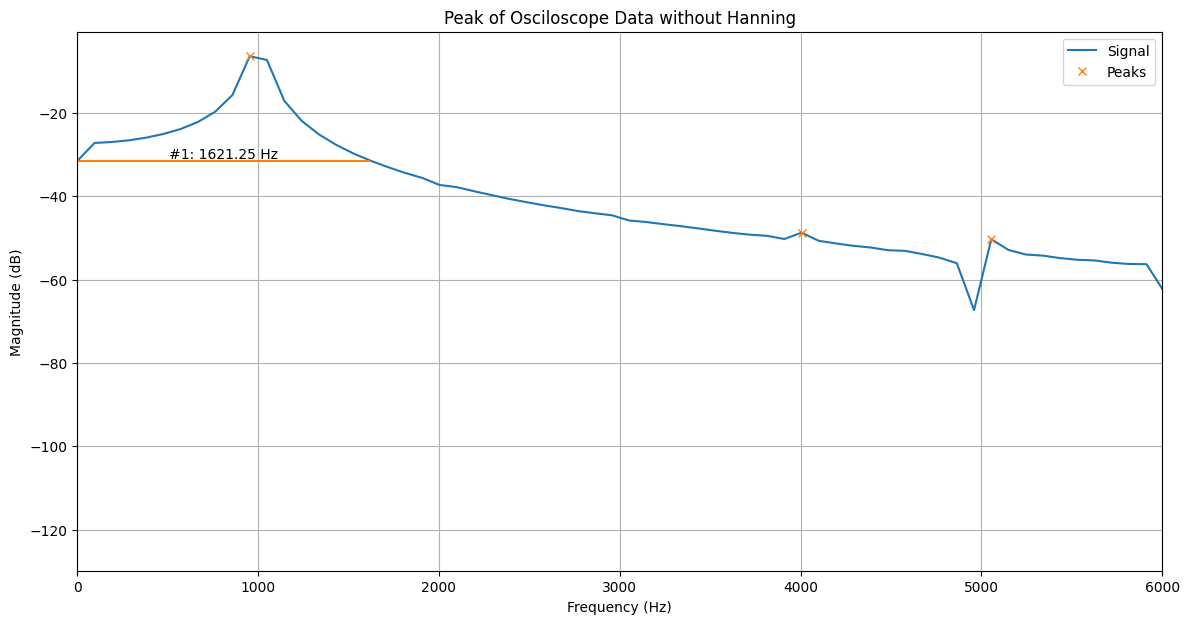

In [ ]:
Pwd_fft_=peak_width(np.array((fft_2ms['Frequency'])),np.array(fft_2ms['Magnitude']),xrang=(0,6000),yrang=None,title='Peak of Osciloscope Data without Hanning')

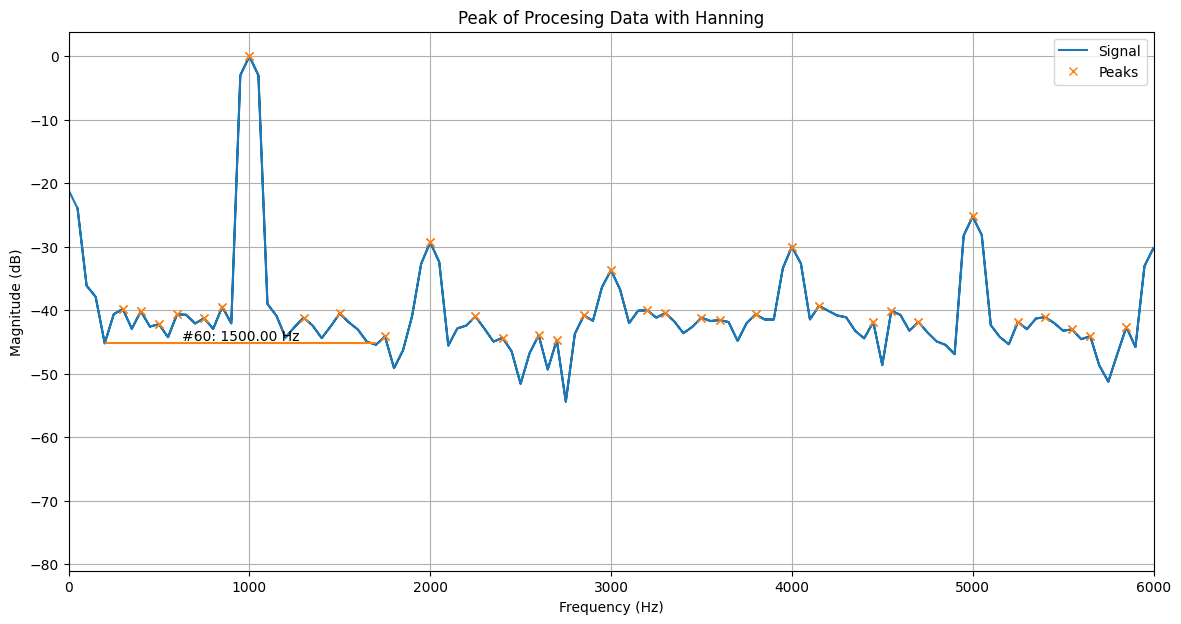

In [ ]:
Pw_ffth_db=peak_width(abs(fft_s_h['freq']),(fft_s_h['ffth_db']),xrang=(0,6000),yrang=None,title='Peak of Procesing Data with Hanning')


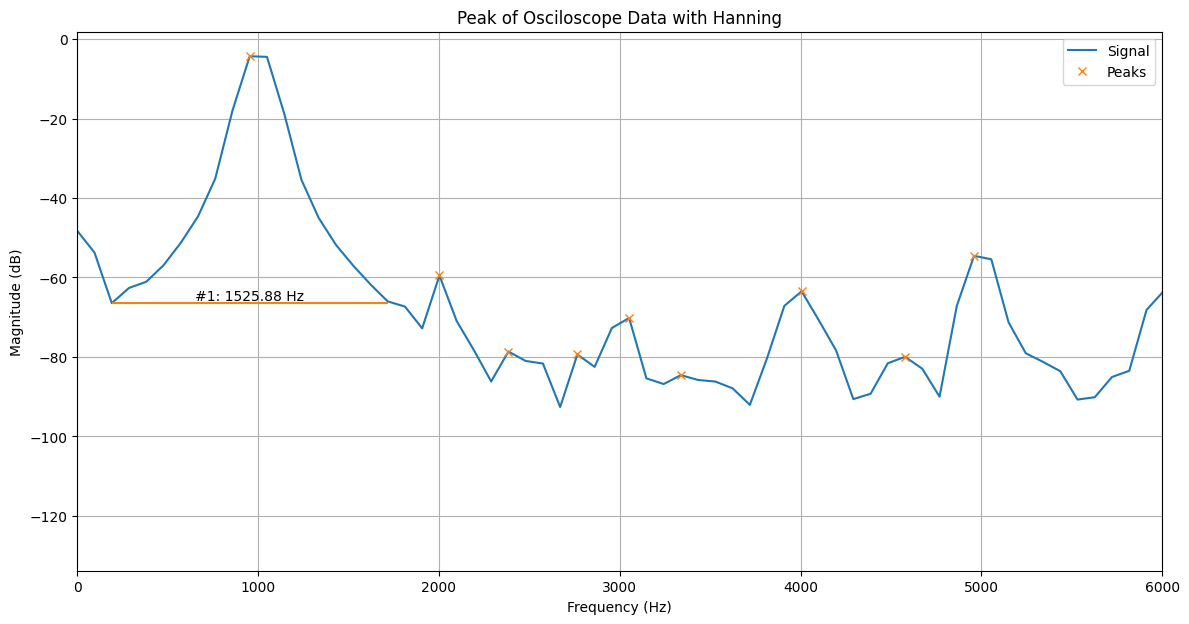

In [ ]:

Pwd_fft_h=peak_width(np.array((ffth_2ms['Frequency'])),np.array(ffth_2ms['Magnitude']),xrang=(0,6000),yrang=None,title='Peak of Osciloscope Data with Hanning')

## analisis 20 ms


In [ ]:
d20ms = read_d('/content/drive/MyDrive/LABO3','s_20ms.csv')
d20ms

,Second,Value
0,-0.009998,-0.016667
1,-0.009998,-0.016667
2,-0.009998,-0.016667
3,-0.009998,-0.016667
4,-0.009998,-0.016667
...,...,...
999995,0.010002,-0.016667
999996,0.010002,-0.016667
999997,0.010002,-0.016667
999998,0.010002,-0.033333


In [ ]:
Obj20ms= signal_h_fft(d20ms['Second'],d20ms['Value'],'Signal 20ms',(20,5))

/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


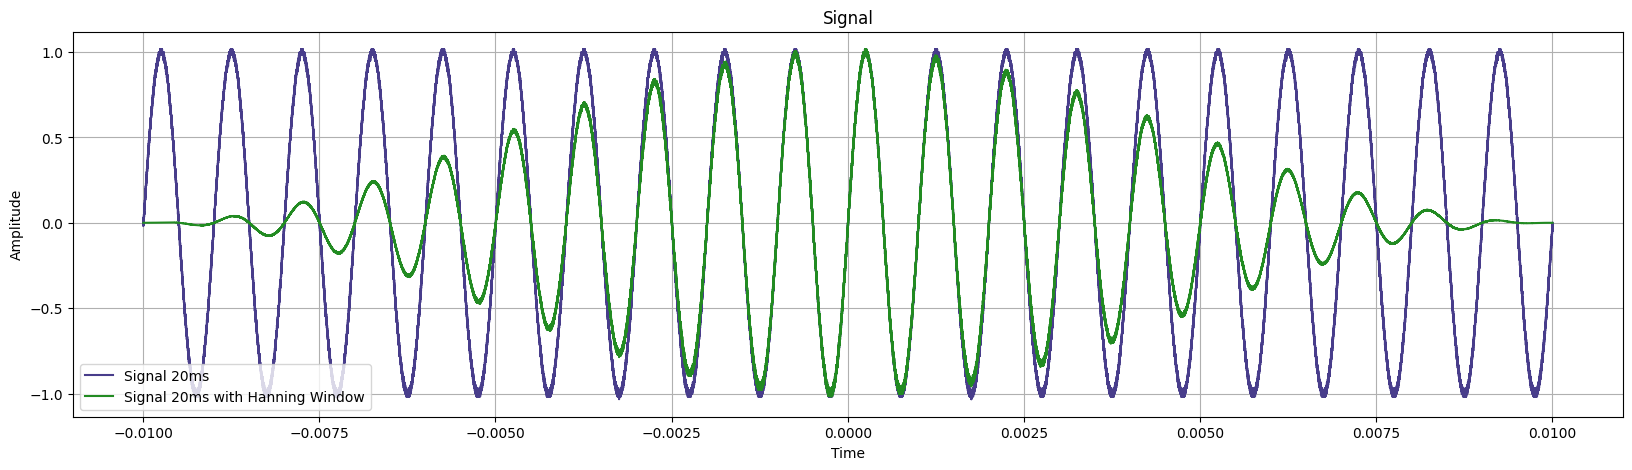

In [ ]:
plot_sig_20ms=Obj20ms.plots_s_h()

In [ ]:
plot_sig_20ms

{'time': array([-0.009998  , -0.00999798, -0.00999796, ...,  0.01000194,
         0.01000196,  0.01000198]),
 'Values': array([-0.01666667, -0.01666667, -0.01666667, ..., -0.01666667,
        -0.03333334, -0.01666667]),
 'Values hanning': array([-0.00000000e+00, -1.64493452e-13, -6.57974732e-13, ...,
        -6.57974732e-13, -3.28986904e-13, -0.00000000e+00])}

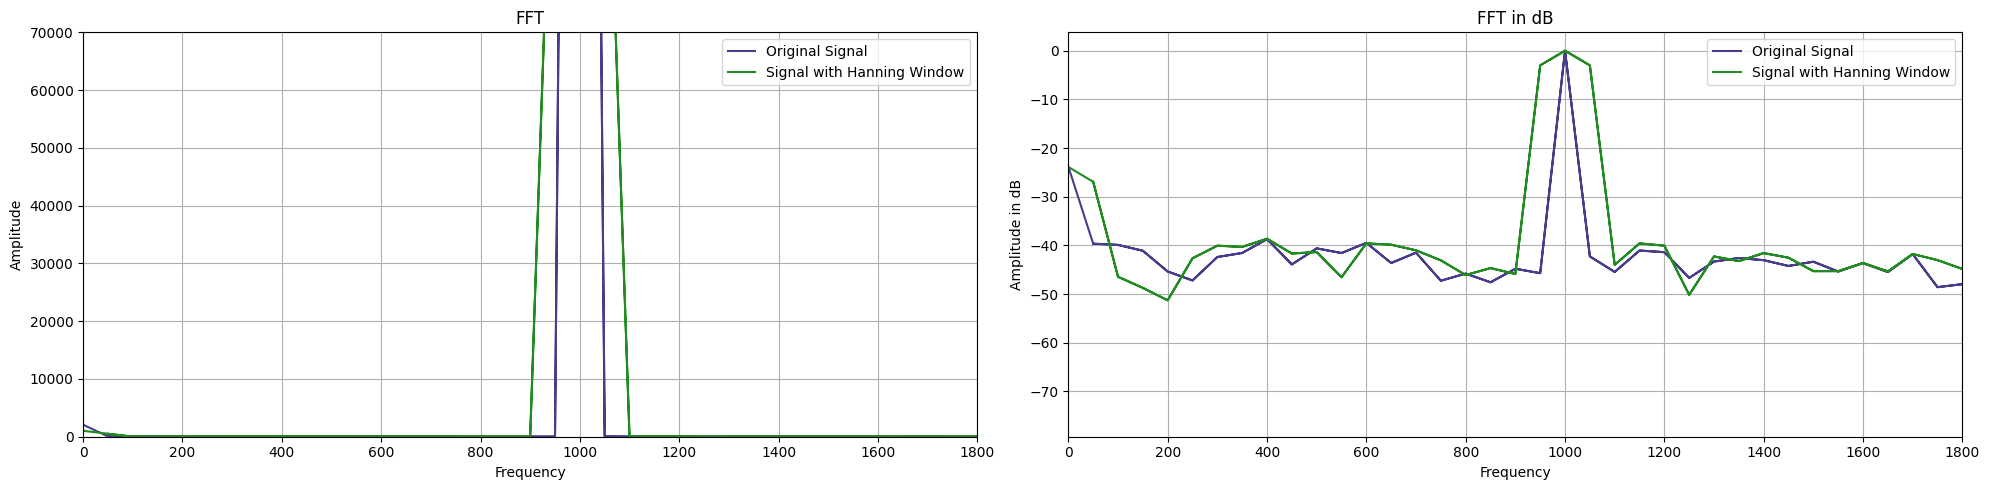

In [ ]:
plot_fft_ffth_20ms = Obj20ms.fft_s_h(xlim=(0,1800),ylim=(0,70000))

In [ ]:
plot_fft_ffth_20ms

{'freq': array([   0.,   50.,  100., ..., -150., -100.,  -50.]),
 'fft': array([-2075.86872782 +0.j        ,   -28.67382887-46.1196684j ,
          -12.38846527-49.72147369j, ...,   -11.87245816+36.99027426j,
          -12.38846527+49.72147369j,   -28.67382887+46.1196684j ]),
 'ffth': array([-1.02359636e+03 +0.j        ,  5.07727672e+02-10.62793696j,
         3.94197487e+00 -4.08345598j, ..., -4.47607909e-01 +3.32252607j,
         3.94197487e+00 +4.08345598j,  5.07727672e+02+10.62793696j]),
 'fft_db': array([-23.82706064, -39.65052934, -39.9028348 , ..., -41.10527422,
        -39.9028348 , -39.65052934]),
 'ffth_db': array([-23.88739365, -26.93142137, -46.44847261, ..., -48.73493975,
        -46.44847261, -26.93142137])}

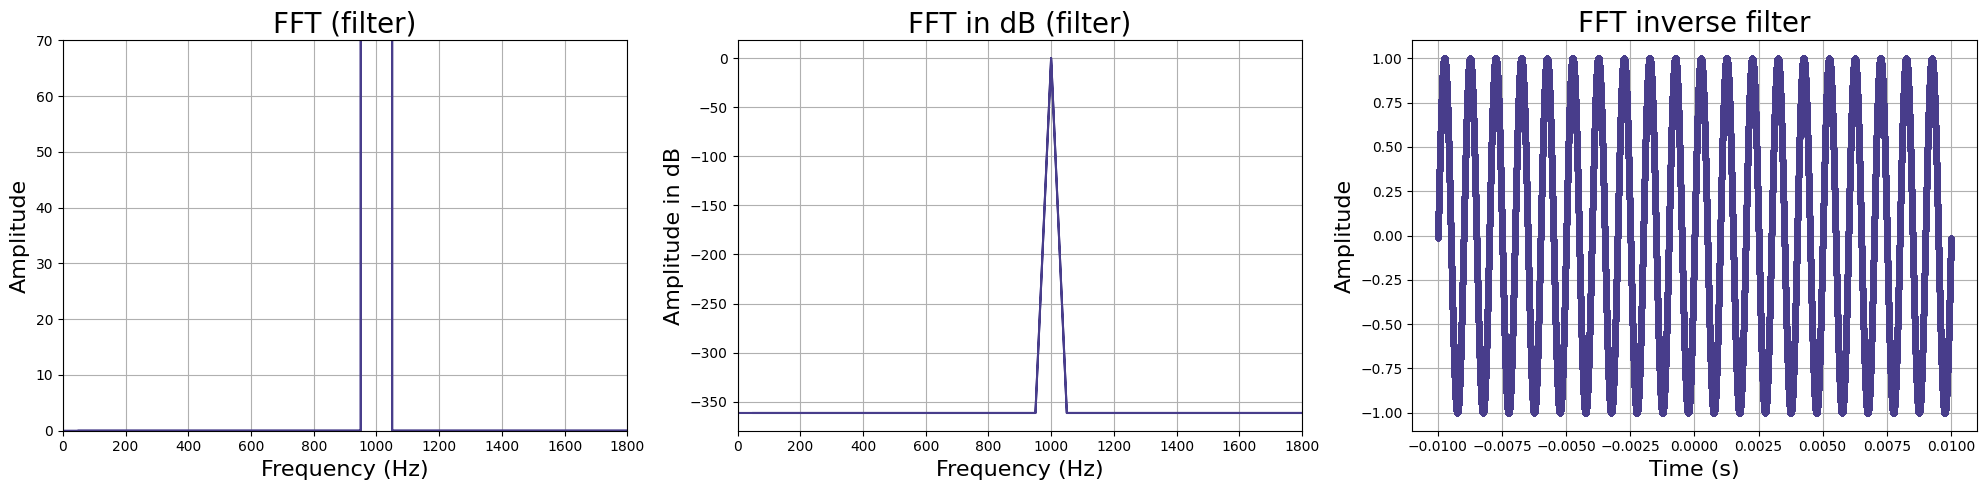

In [ ]:
cut_peak_20ms = Obj20ms.cutpeak( 'FFT', 10000, 'low', xlim=(0,1800), ylim=(0,70))

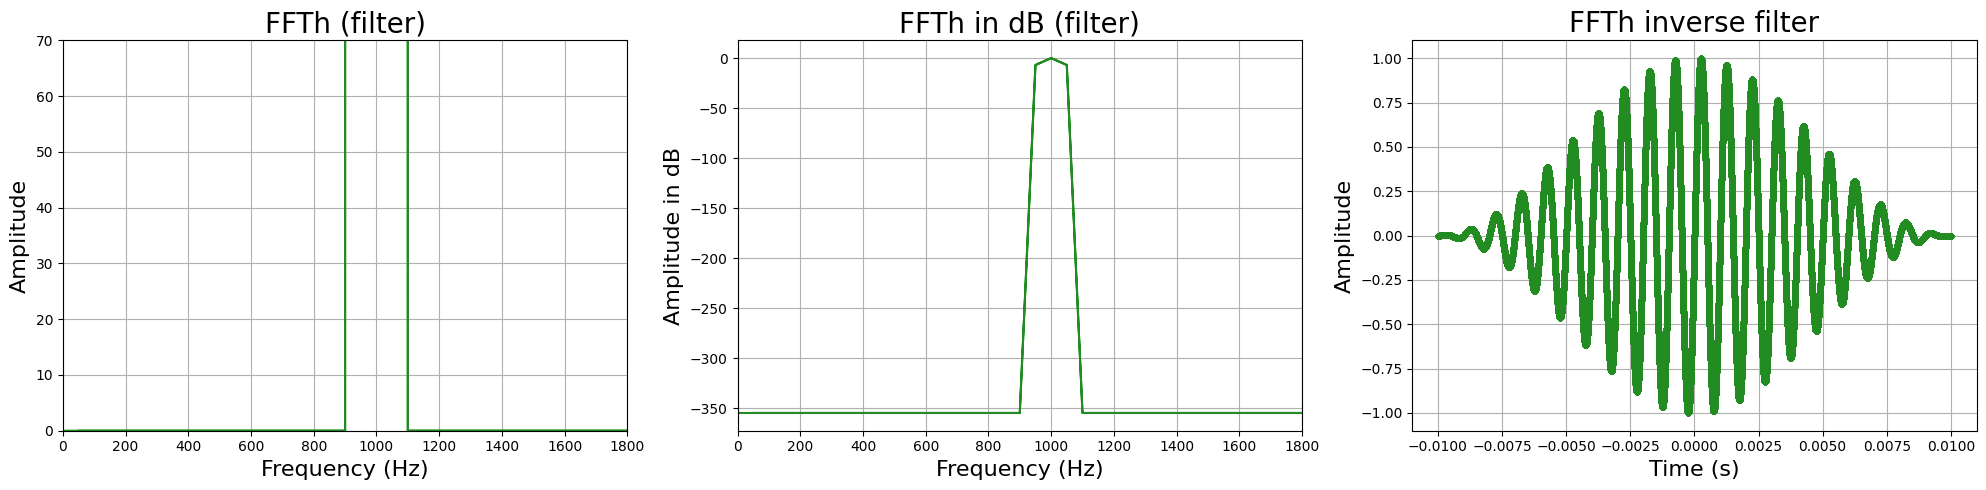

In [ ]:
cut_peakh_20ms = Obj20ms.cutpeak( 'FFTh', 10000, 'low', xlim=(0,1800), ylim=(0,70))

In [ ]:
plot_fft_ffth_20ms

{'freq': array([   0.,   50.,  100., ..., -150., -100.,  -50.]),
 'fft': array([-2075.86872782 +0.j        ,   -28.67382887-46.1196684j ,
          -12.38846527-49.72147369j, ...,   -11.87245816+36.99027426j,
          -12.38846527+49.72147369j,   -28.67382887+46.1196684j ]),
 'ffth': array([-1.02359636e+03 +0.j        ,  5.07727672e+02-10.62793696j,
         3.94197487e+00 -4.08345598j, ..., -4.47607909e-01 +3.32252607j,
         3.94197487e+00 +4.08345598j,  5.07727672e+02+10.62793696j]),
 'fft_db': array([-23.82706064, -39.65052934, -39.9028348 , ..., -41.10527422,
        -39.9028348 , -39.65052934]),
 'ffth_db': array([-23.88739365, -26.93142137, -46.44847261, ..., -48.73493975,
        -46.44847261, -26.93142137])}

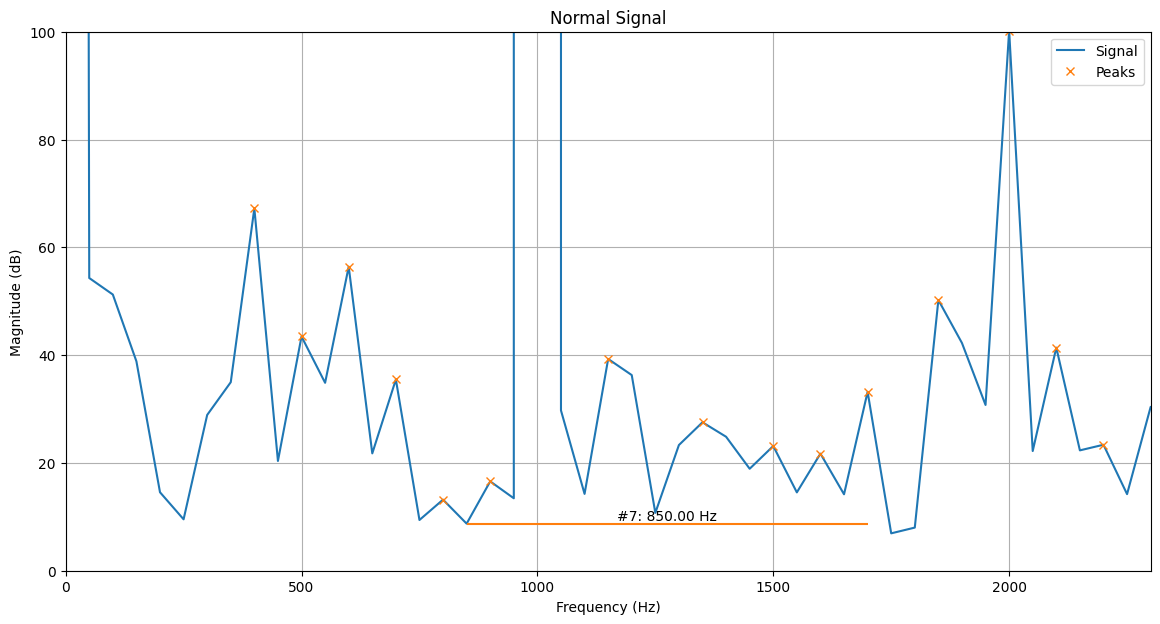

In [ ]:
A=peak_width(plot_fft_ffth_20ms['freq'],np.abs(plot_fft_ffth_20ms['fft']),xrang=(0,2300),yrang=(0,100),title='Normal Signal')

In [ ]:
A[1]

{'Amplitude': 501078.7096206089,
 'Widtth': 850.000000005048,
 'Range width': [850.000000005048, 1700.000000010096]}

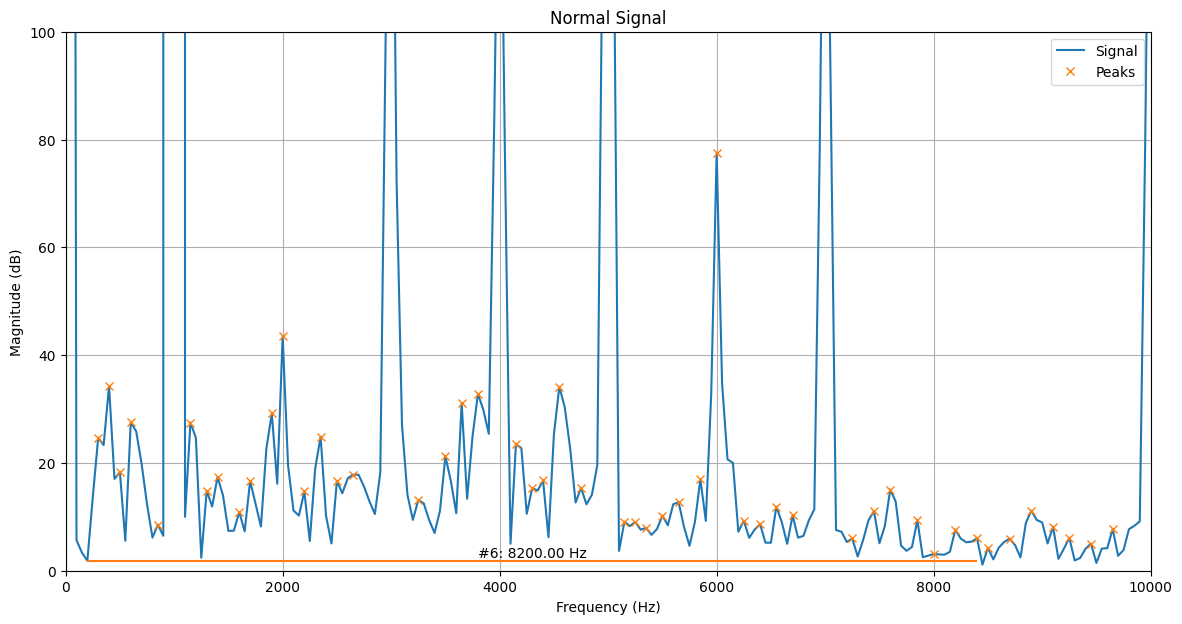

In [ ]:
B=peak_width(plot_fft_ffth_20ms['freq'],np.abs(plot_fft_ffth_20ms['ffth']),xrang=(0,10000),yrang=(0,100),title='Normal Signal')

In [ ]:
B[1]

{'Amplitude': 250534.82143905226,
 'Widtth': 8200.000000048698,
 'Range width': [200.00000000118777, 8400.000000049886]}

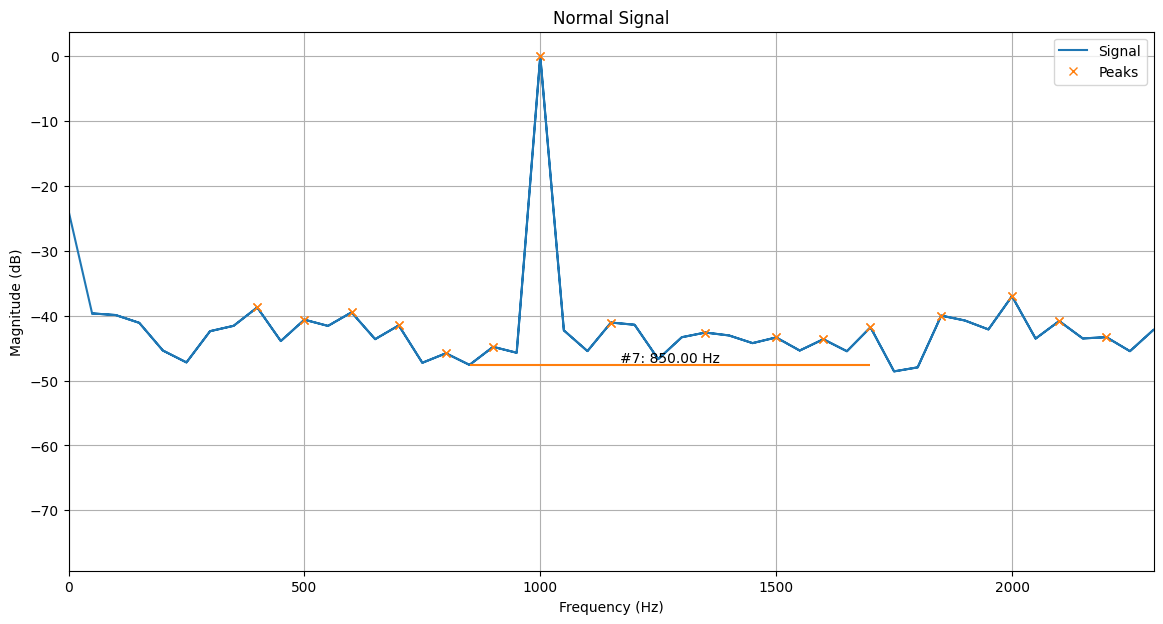

In [ ]:
C=peak_width(np.abs(plot_fft_ffth_20ms['freq']),(plot_fft_ffth_20ms['fft_db']),xrang=(0,2300),title='Normal Signal')

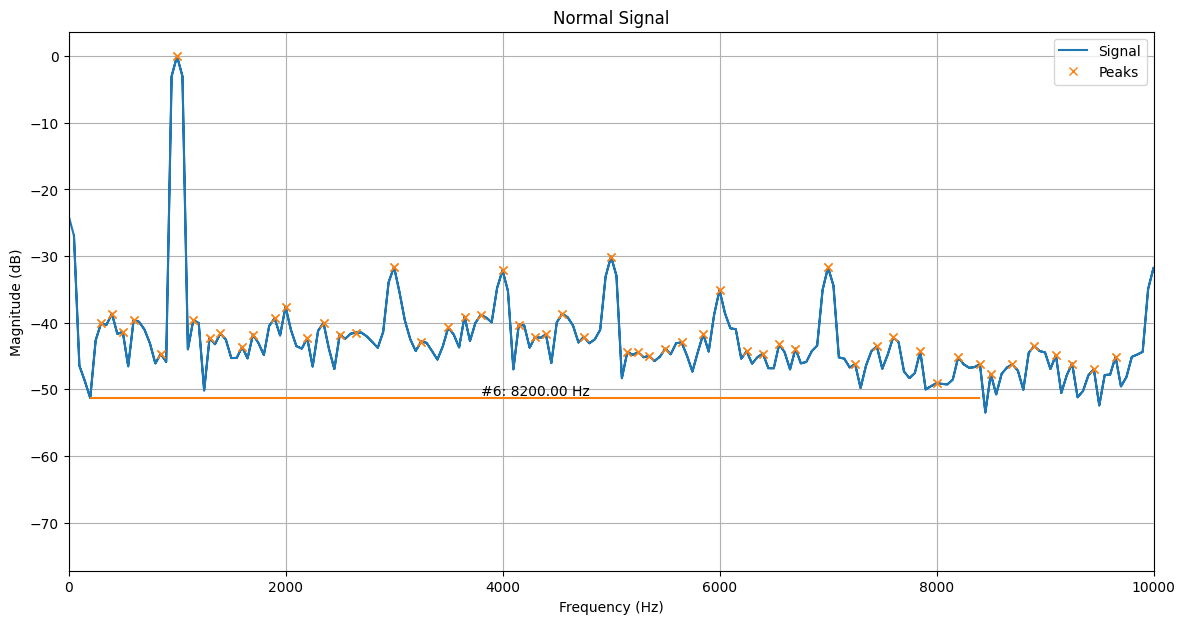

In [ ]:
D=peak_width(np.abs(plot_fft_ffth_20ms['freq']),(plot_fft_ffth_20ms['ffth_db']),xrang=(0,10000),title='Normal Signal')

In [ ]:
D[1]

{'Amplitude': 0.0,
 'Widtth': 8200.000000048698,
 'Range width': [200.00000000118777, 8400.000000049886]}

In [ ]:
s20ms_h=d20ms = read_d('/content/drive/MyDrive/LABO3','fft_20ms.csv')

In [ ]:
s20ms_h

,Frequency,Real part,Imaginary part,Magnitude,Angle
0,0.000000e+00,-1.524437e-03,0.000000e+00,-56.963500,3.141593
1,9.536743e+01,5.013519e-04,2.068526e-05,-67.875073,0.234561
2,1.907349e+02,-5.366632e-04,-2.287593e-06,-65.343077,1.041693
3,2.861023e+02,-5.952157e-04,4.298504e-05,-64.475087,3.071529
4,3.814697e+02,-9.672799e-04,1.238342e-05,-60.293160,3.128762
...,...,...,...,...,...
262139,2.499952e+07,-2.729004e-06,5.181097e-06,-96.234613,0.874777
262140,2.499962e+07,6.256267e-07,-1.935948e-05,-90.484803,-1.678140
262141,2.499971e+07,-2.954101e-06,1.325319e-05,-95.124180,1.863416
262142,2.499981e+07,1.047221e-05,-4.689232e-06,-100.242503,-0.825593


In [ ]:
x=np.array(s20ms_h['Frequency'])
y=np.array(s20ms_h['Magnitude'])

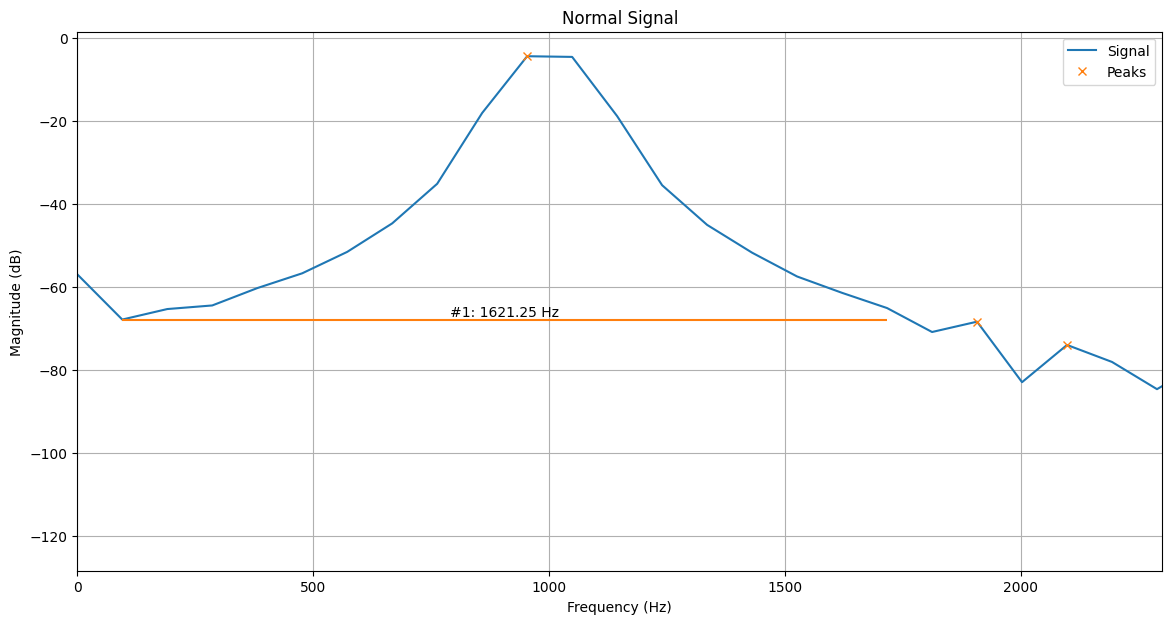

In [ ]:
E=peak_width(x,y,xrang=(0,2300),title='Normal Signal')

##Analisis 20ms

### Analisis de la data

In [ ]:
Signal_2ms = read_d('/content/drive/MyDrive/LABO3','s_20ms.csv')
#datos de la fft y ffth para realizar la correspondiente comparativa
#fft_2ms = read_d('/content/drive/MyDrive/LABO3','fft_20ms.csv')
ffth_2ms =read_d('/content/drive/MyDrive/LABO3','fft_20ms.csv')


/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


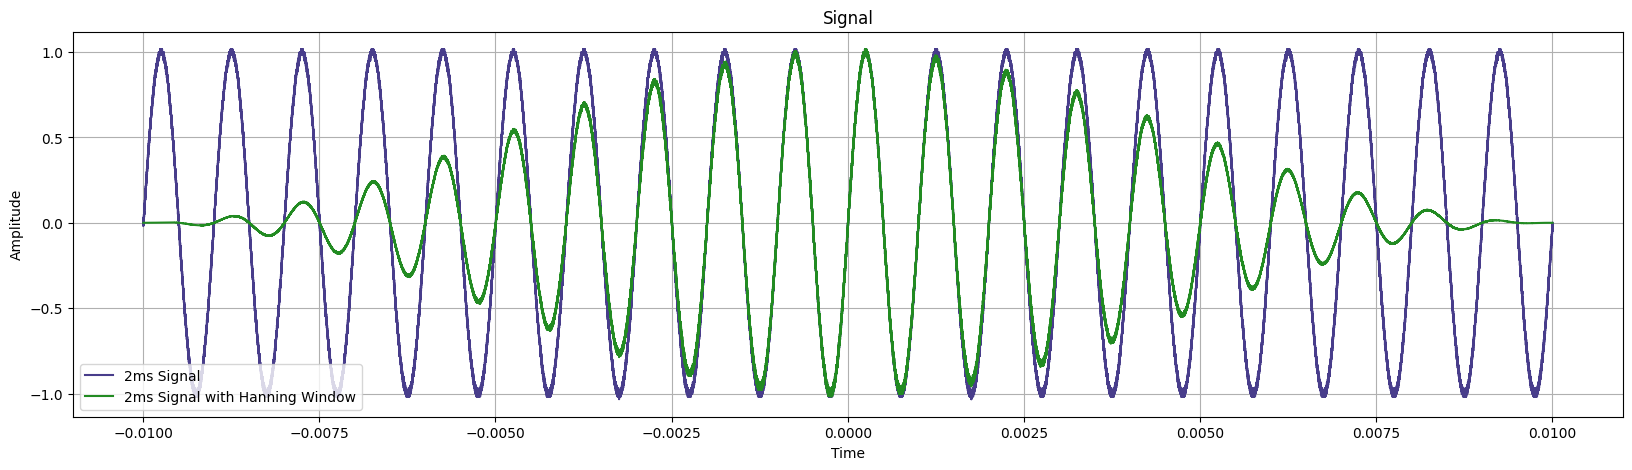

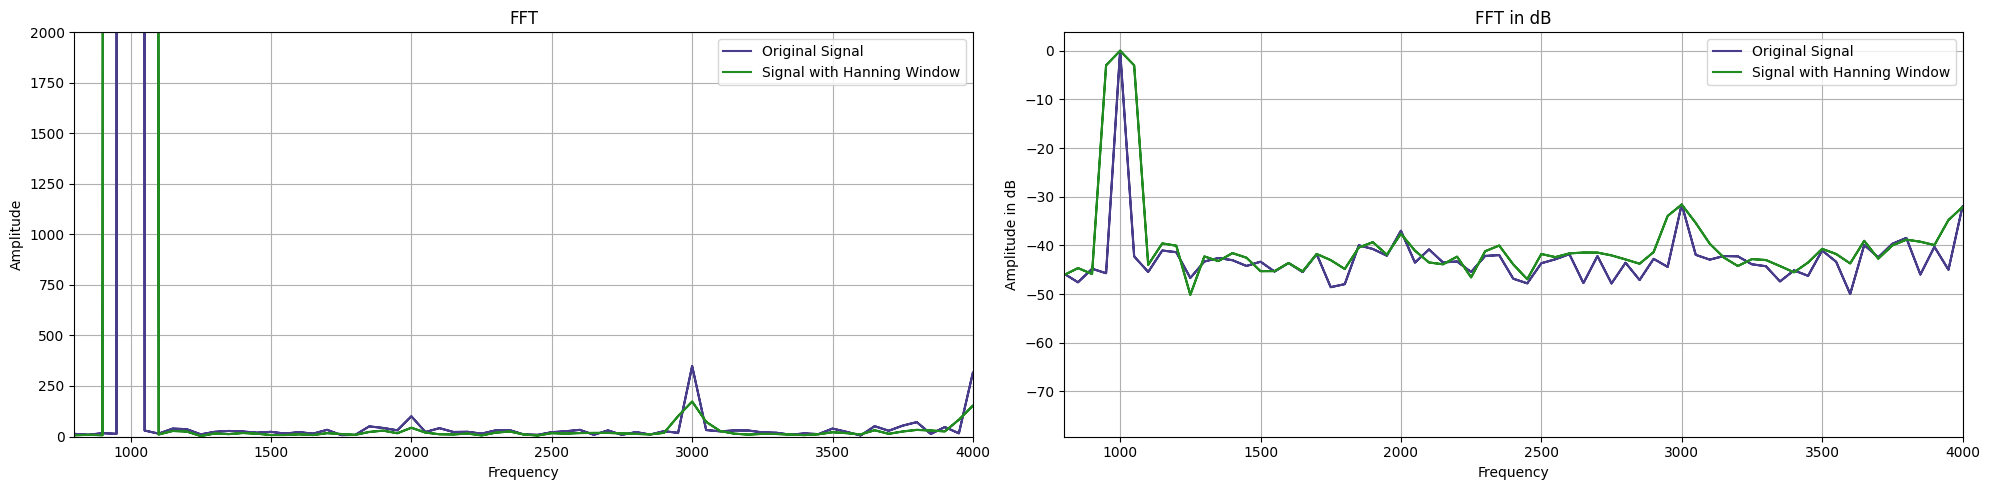

In [ ]:
FFT = signal_h_fft(Signal_2ms['Second'],Signal_2ms['Value'],'2ms Signal',(20,5))
haning = FFT.plots_s_h() # grafica y regesa los valores de la senal con el hannig
fft_s_h = FFT.fft_s_h(xlim=(800,4000),ylim=(-1,2000)) # regresa los. valores de las. frecuencias y de la fft y el fft del hanning asi como los valores en dB
#Cut_fft= FFT.cutpeak(tysignal='FFT',threshold=4000,filter_mode='low',ylim=(0,20),xlim=(800,4200)) # experimental aplica un pic cutting para senal de la fft o de ffth
#Cut_ffth= FFT.cutpeak(tysignal='FFTh',threshold=4000,filter_mode='low',ylim=(0,20),xlim=(800,4200))



### Determinacion del ancho de la Data

haciendo uso de la variable fft_s_h que retorna. los. valores de la fft y el hanning de la fft calcularemos el pico

In [ ]:
fft_s_h

{'freq': array([   0.,   50.,  100., ..., -150., -100.,  -50.]),
 'fft': array([-3853.27837158  +0.j        ,    98.11560221 +45.92249086j,
           23.22909805+132.35618551j, ...,   -29.59312053 +24.33168116j,
           23.22909805-132.35618551j,    98.11560221 -45.92249086j]),
 'ffth': array([-1975.69520857 +0.j        ,  1006.57040108-10.12494397j,
           -5.51672925+60.77994938j, ...,   -21.09103138+34.95919737j,
           -5.51672925-60.77994938j,  1006.57040108+10.12494397j]),
 'fft_db': array([-21.16079066, -36.67157791, -35.73577623, ..., -41.18578452,
        -35.73577623, -36.67157791]),
 'ffth_db': array([-21.05170027, -23.98023848, -36.15348023, ..., -37.89925159,
        -36.15348023, -23.98023848])}

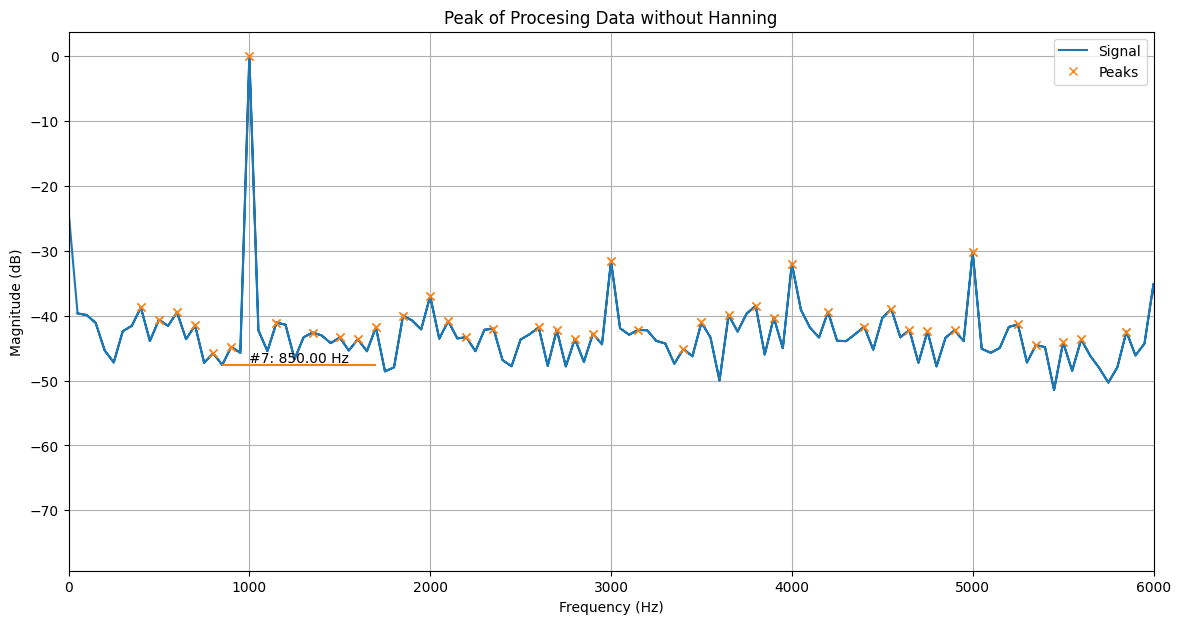

In [ ]:
Pw_fft_db=peak_width(abs(fft_s_h['freq']),(fft_s_h['fft_db']),xrang=(0,6000),yrang=None,title='Peak of Procesing Data without Hanning')


In [ ]:
Pwd_fft_os=peak_width(np.array((fft_2ms['Frequency'])),np.array(fft_2ms['Magnitude']),xrang=(0,6000),yrang=None,title='Peak of Osciloscope Data without Hanning')

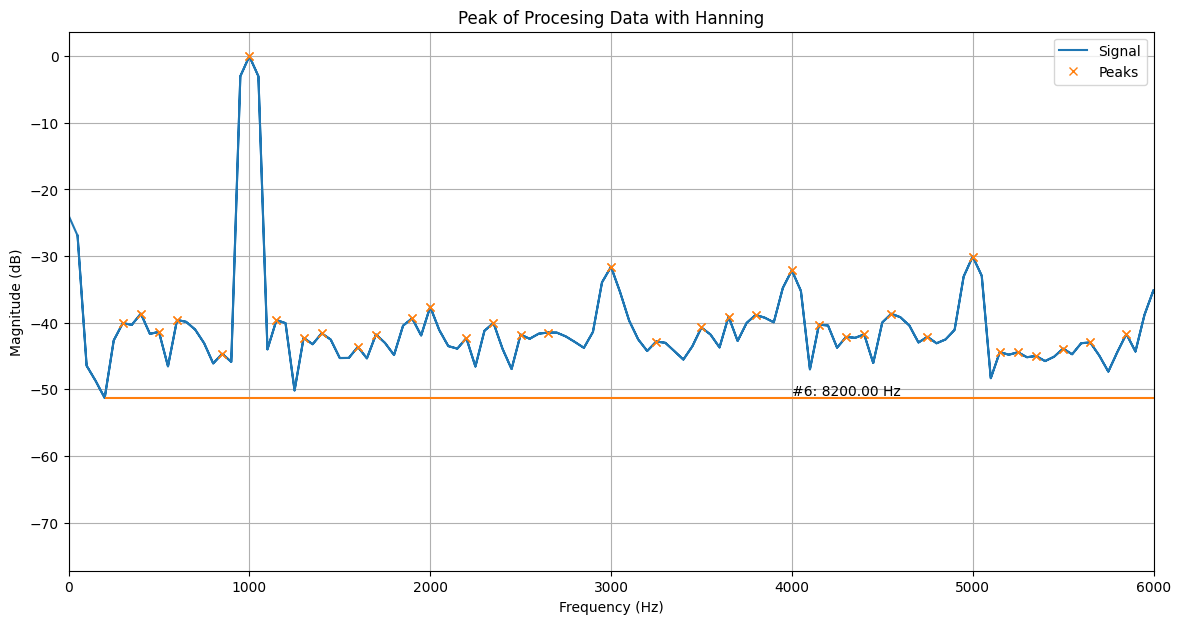

In [ ]:
Pw_ffth_db=peak_width(abs(fft_s_h['freq']),(fft_s_h['ffth_db']),xrang=(0,6000),yrang=None,title='Peak of Procesing Data with Hanning')


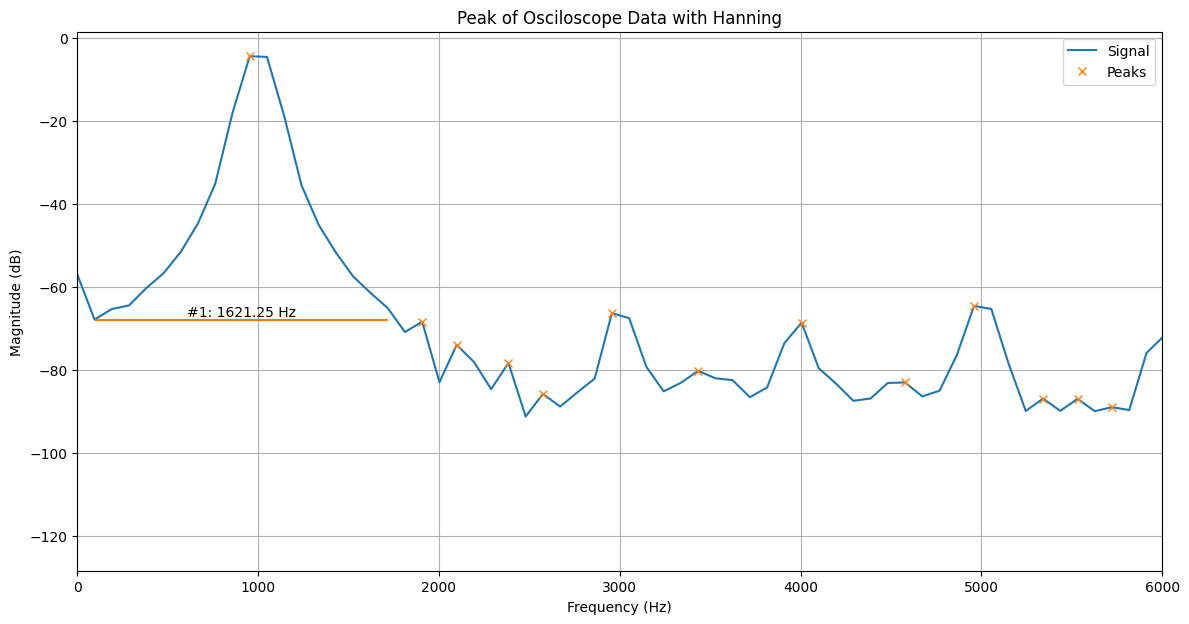

In [ ]:

Pwd_ffth_os=peak_width(np.array((ffth_2ms['Frequency'])),np.array(ffth_2ms['Magnitude']),xrang=(0,6000),yrang=None,title='Peak of Osciloscope Data with Hanning')